In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =5e-25

nband = 115

ng =4

ng_refs = (/ 4 /) 

nref =1

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

tsfc =257

vstar = 1100

data w_diffuse
     &     /1.66 , 1.66 , 1.7 , 1.8/

data wgt
     &     /0.3 , 0.45 , 0.6 , 0.95/

atmosphere_profiles/saw75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

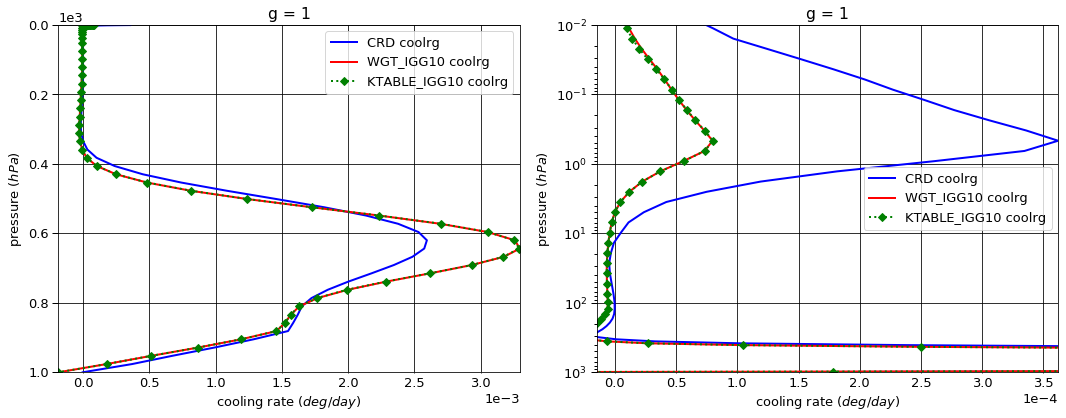

# Figure: cooling rate g-group 2

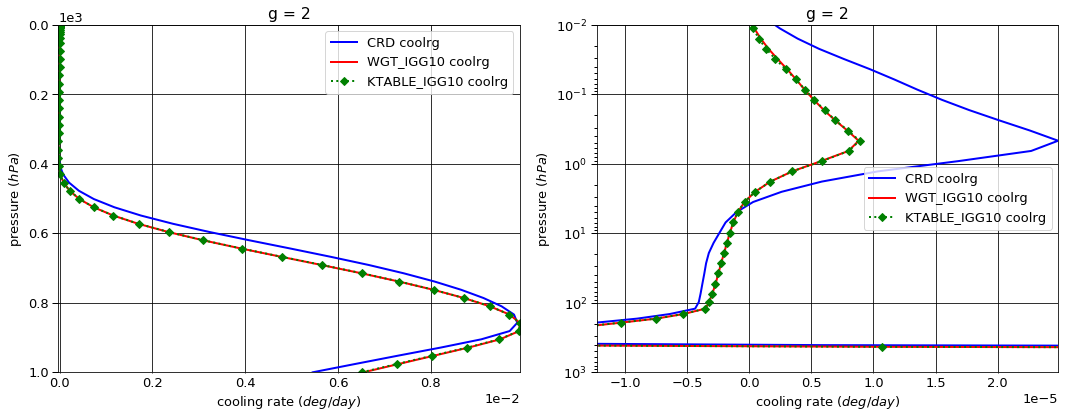

# Figure: cooling rate g-group 3

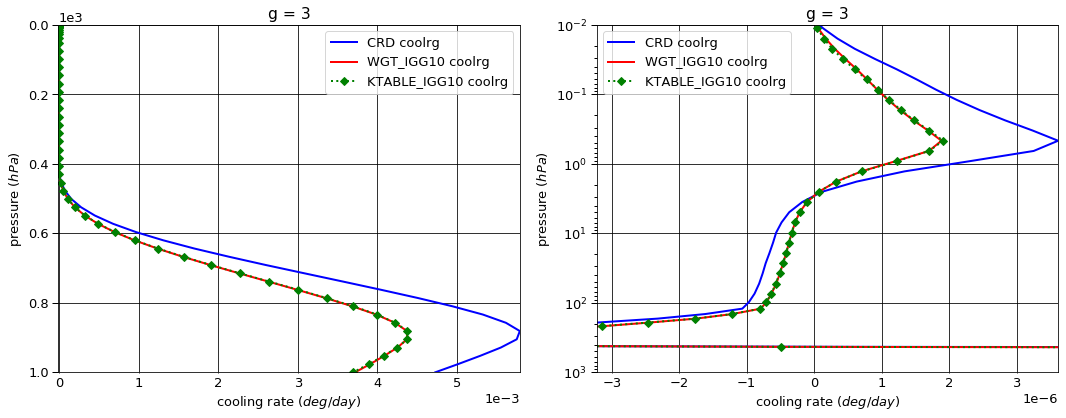

# Figure: cooling rate g-group 4

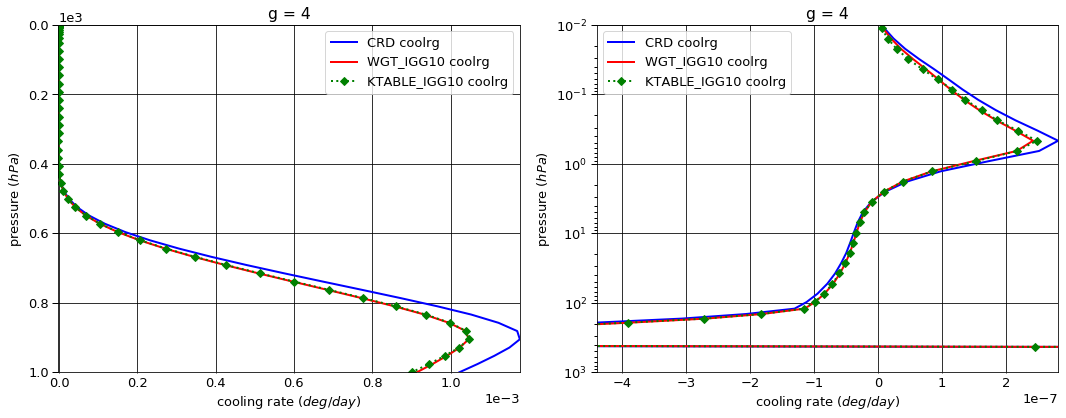

# Figure: cooling rate g-group total

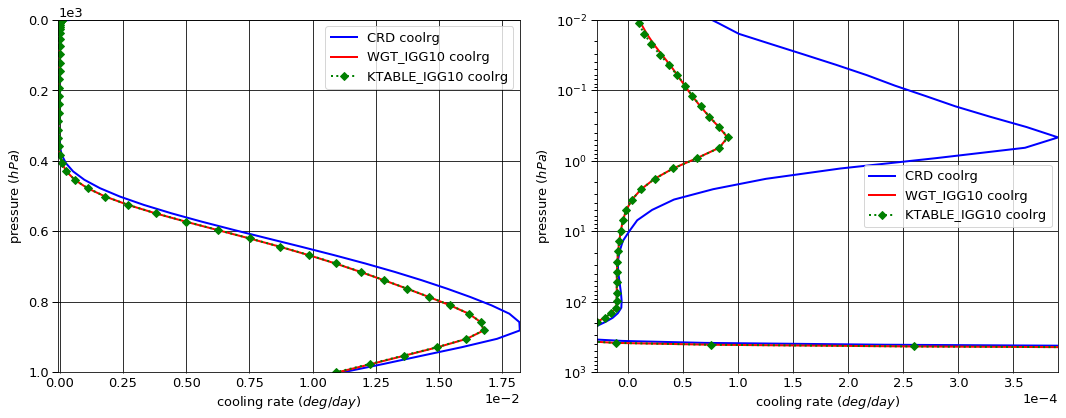

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.115218  0.000000 -0.115218
  1013.0   76    -0.154042  0.152577 -0.001464
2 0.0      1     -0.854111  0.000000 -0.854111
  1013.0   76    -0.889114  0.429194 -0.459920
3 0.0      1     -3.543227  0.000000 -3.543227
  1013.0   76    -3.551848  0.215546 -3.336302
4 0.0      1     -5.700769  0.000000 -5.700769
  1013.0   76    -5.702121  0.042416 -5.659705


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.116177  0.000000 -0.116177
  1013.0   76    -0.154042  0.157549  0.003507
2 0.0      1     -0.864778  0.000000 -0.864778
  1013.0   76    -0.889114  0.400224 -0.488890
3 0.0      1     -3.545745  0.000000 -3.545745
  1013.0   76    -3.551848  0.161760 -3.390087
4 0.0      1     -5.700939  0.000000 -5.700939
  1013.0   76    -5.702121  0.037658 -5.664463


KTABLE_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.116127  0.000000 -0.116127
  1013.0   76    -0.154042  0.157553  0.003512
2 0.0      1     -0.864671  0.000000 -0.864671
  1013.0   76    -0.889114  0.400147 -0.488967
3 0.0      1     -3.545696  0.000000 -3.545696
  1013.0   76    -3.551848  0.161958 -3.389890
4 0.0      1     -5.700922  0.000000 -5.700922
  1013.0   76    -5.702121  0.037705 -5.664416


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000959  0.000000 -0.000959
  1013.0   76     0.000000  0.004971  0.004971
2 0.0      1     -0.010666  0.000000 -0.010666
  1013.0   76     0.000000 -0.028970 -0.028970
3 0.0      1     -0.002519  0.000000 -0.002519
  1013.0   76     0.000000 -0.053786 -0.053786
4 0.0      1     -0.000170  0.000000 -0.000170
  1013.0   76     0.000000 -0.004758 -0.004758


KTABLE_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000908  0.000000 -0.000908
  1013.0   76     0.000000  0.004976  0.004976
2 0.0      1     -0.010559  0.000000 -0.010559
  1013.0   76     0.000000 -0.029047 -0.029047
3 0.0      1     -0.002469  0.000000 -0.002469
  1013.0   76     0.000000 -0.053588 -0.053588
4 0.0      1     -0.000153  0.000000 -0.000153
  1013.0   76     0.000000 -0.004711 -0.004711

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.077171e-06
  1001.112500 75    -2.908299e-06
2 0.000312    1     -2.523256e-06
  1001.112500 75     5.454391e-03
3 0.000312    1     -5.785287e-07
  1001.112500 75     4.726225e-03
4 0.000312    1     -3.335864e-08
  1001.112500 75     1.022352e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -6.229298e-06
  1001.112500 75    -1.863740e-04
2 0.000312    1     -1.300373e-06
  1001.112500 75     6.549018e-03
3 0.000312    1     -3.121039e-07
  1001.112500 75     3.718974e-03
4 0.000312    1     -2.950403e-08
  1001.112500 75     9.137934e-04


KTABLE_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -4.732181e-06
  1001.112500 75    -1.852301e-04
2 0.000312    1     -9.517871e-07
  1001.112500 75     6.511265e-03
3 0.000312    1     -2.426247e-07
  1001.112500 75     3.693006e-03
4 0.000312    1     -2.013767e-08
  1001.112500 75     9.006036e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.152127e-06
  1001.112500 75    -1.834657e-04
2 0.000312    1      1.222883e-06
  1001.112500 75     1.094628e-03
3 0.000312    1      2.664249e-07
  1001.112500 75    -1.007252e-03
4 0.000312    1      3.854616e-09
  1001.112500 75    -1.085582e-04


KTABLE_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.655009e-06
  1001.112500 75    -1.823218e-04
2 0.000312    1      1.571469e-06
  1001.112500 75     1.056874e-03
3 0.000312    1      3.359040e-07
  1001.112500 75    -1.033219e-03
4 0.000312    1      1.322098e-08
  1001.112500 75    -1.217480e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-10.213325,0.000000,-10.213325
1013.0,76,-10.297125,0.839734,-9.457391



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-10.227639,0.000000,-10.227639
1013.0,76,-10.297125,0.757191,-9.539933



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-10.227415,0.000000,-10.227415
1013.0,76,-10.297125,0.757364,-9.539761



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.014314,0.000000,-0.014314
1013.0,76,0.000000,-0.082543,-0.082543



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.014089,0.00000,-0.014089
1013.0,76,0.000000,-0.08237,-0.082370


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000006
1001.112500,75,0.011200



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000008
1001.112500,75,0.010995



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000006
1001.112500,75,0.010920



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000002
1001.112500,75,-0.000205



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,2.655848e-07
1001.112500,75,-2.804150e-04


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.015957,0.014906
2,0.089391,0.086202
3,0.357652,0.344282
4,0.537000,0.554611


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.089438e-22
2,7.380948e-24
3,5.000596e-25
4,3.773541e-26


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.089438e-22,NaN,0.015957,0.014906,0.015957,0.014906,600.0
2,7.380948e-24,0.067750,0.089391,0.086202,0.105348,0.101108,600.0
3,5.000596e-25,0.067750,0.357652,0.344282,0.463000,0.445389,600.0
4,3.773541e-26,0.075462,0.537000,0.554611,1.000000,1.000000,600.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     2.438307e-22  5.766433e-24  42.284486  6.573223e-09
      2 0.000312     3.329240e-24  1.353583e-25  24.595752  1.339248e-10
      3 0.000312     1.398763e-25  9.082935e-27  15.399897  7.456619e-12
      4 0.000312     5.220476e-27  3.725776e-28  14.011783  4.239391e-13
2     1 0.000750     2.522699e-22  5.814769e-24  43.384327  2.735611e-09
      2 0.000750     3.446765e-24  1.371164e-25  25.137509  5.579040e-11
      3 0.000750     1.442821e-25  9.239676e-27  15.615491  3.096254e-12
      4 0.000750     5.409292e-27  3.800908e-28  14.231578  1.769228e-13
3     1 0.001052     2.700245e-22  5.913137e-24  45.665179  4.095916e-09
      2 0.001052     3.695998e-24  1.406708e-25  26.274096  8.372885e-11
      3 0.001052     1.536220e-25  9.557816e-27  16.072919  4.617838e-12
      4 0.001052     5.816442e-27  3.953912e-28  14.710603  2.667572e-13
4     1 0.001476     2.889950e-22  6.017111e-24  48.028864  6.135109e-09
      2 0.001476     3.965512e-24  1.443560e-25  27.470367  1.257840e-10
      3 0.001476     1.637231e-25  9.884836e-27  16.563052  6.896158e-12
      4 0.001476     6.267236e-27  4.112494e-28  15.239502  4.031858e-13
5     1 0.002070     3.089958e-22  6.125343e-24  50.445479  9.180140e-09
      2 0.002070     4.253357e-24  1.481427e-25  28.711211  1.888807e-10
      3 0.002070     1.745240e-25  1.021610e-26  17.083224  1.029841e-11
      4 0.002070     6.761076e-27  4.274817e-28  15.816061  6.099866e-13
6     1 0.002904     3.300584e-22  6.237591e-24  52.914395  1.372673e-08
      2 0.002904     4.560686e-24  1.520519e-25  29.994275  2.835979e-10
      3 0.002904     1.860832e-25  1.055101e-26  17.636531  1.538462e-11
      4 0.002904     7.302801e-27  4.441307e-28  16.442909  9.240927e-13
7     1 0.004074     3.522141e-22  6.353648e-24  55.434936  2.050859e-08
      2 0.004074     4.888728e-24  1.561092e-25  31.316077  4.257337e-10
      3 0.004074     1.984657e-25  1.088915e-26  18.226015  2.299010e-11
      4 0.004074     7.897863e-27  4.612929e-28  17.121146  1.401743e-12
8     1 0.005714     3.754978e-22  6.473492e-24  58.005443  3.061379e-08
      2 0.005714     5.238850e-24  1.603449e-25  32.672390  6.389385e-10
      3 0.005714     2.117466e-25  1.123058e-26  18.854455  3.436522e-11
      4 0.005714     8.552515e-27  4.791295e-28  17.850113  2.128908e-12
9     1 0.008015     3.999376e-22  6.597429e-24  60.620226  4.566110e-08
      2 0.008015     5.612417e-24  1.647928e-25  34.057420  9.587490e-10
      3 0.008015     2.260056e-25  1.157604e-26  19.523575  5.139049e-11
      4 0.008015     9.273632e-27  4.978600e-28  18.626988  3.237643e-12
10    1 0.011243     4.255674e-22  6.726385e-24  63.268364  6.804736e-08
      2 0.011243     6.010983e-24  1.694961e-25  35.463837  1.438356e-09
      3 0.011243     2.413364e-25  1.192744e-26  20.233710  7.688576e-11
      4 0.011243     1.006918e-26  5.177691e-28  19.447236  4.930428e-12
11    1 0.015771     4.524150e-22  6.862162e-24  65.928933  1.013272e-07
      2 0.015771     6.436139e-24  1.745124e-25  36.880697  2.157547e-09
      3 0.015771     2.578407e-25  1.228821e-26  20.982769  1.150932e-10
      4 0.015771     1.094801e-26  5.392035e-28  20.304046  7.518765e-12
12    1 0.022122     4.805064e-22  7.007855e-24  68.566838  1.507594e-07
      2 0.022122     6.889581e-24  1.799255e-25  38.291304  3.235800e-09
      3 0.022122     2.756324e-25  1.266369e-26  21.765576  1.723911e-10
      4 0.022122     1.192015e-26  5.626009e-28  21.187578  1.148189e-11
13    1 0.031031     5.097316e-22  7.167897e-24  71.113130  2.240699e-07
      2 0.031031     7.370923e-24  1.858424e-25  39.662223  4.850819e-09
      3 0.031031     2.947512e-25  1.306010e-26  22.568833  2.583148e-10
      4 0.031031     1.299193e-26  5.884433e-28  22.078474  1.755218e-11
14    1 0.043528     5.366158e-22  7.337728e-24  73.131063  3.305914e-07
      2 0.0

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
